# Surfacing Promotions M2

In [ ]:
import os 
import pandas as pd
import sys

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(src_path)

from src import query_engines, dataframe_visualizer

q = query_engines.QueryEngines()

In [ ]:
sys.

# Q1: What are the different experiment ids

In [9]:
QUERY_NAME = 'experiments.sql' # With sql
START_DATE = "'2024-07-01'"
END_DATE = "'2024-12-02'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=None
    
)

df  = q.query_run_starburst()
df

/Users/jordicremades/Documents/repos/central-node/src/query_engines.py:138: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/22a960d13dbd357db924f15f2b209f9373c41f0b5c077d7ba7315fea8e8a68dc


,experiment_toggle_id,experiment_id,first_exposure_date
0,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10060-ZAP_SURFACING_PROMO...,2024-07-01
1,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10715-ZAP_SURFACING_PROMO...,2024-07-04
2,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10715-ZAP_SURFACING_PROMO...,2024-07-04
3,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11134-ZAP_SURFACING_PROMO...,2024-07-18
4,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11986-ZAP_SURFACING_PROMO...,2024-08-19
5,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11986-ZAP_SURFACING_PROMO...,2024-08-26
6,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12294-ZAP_SURFACING_PROMO...,2024-09-03
7,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12327-ZAP_SURFACING_PROMO...,2024-09-05
8,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12371-ZAP_SURFACING_PROMO...,2024-09-06
9,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12371-ZAP_SURFACING_PROMO...,2024-09-17


# Q2: Check the evolution of variants

In [14]:
QUERY_NAME = 'exposures.sql' # With sql
START_DATE = "'2024-10-01'"
END_DATE = "'2024-12-02'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=None
    
)

df  = q.query_run_starburst()
df.head()

Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/feec2a576a9bfbfed7084fe32f6a7f749d8ae42b9ddbde8b600db898a3ec7e35


,customer_id,variant,first_exposure_at
0,141568392,Control Group,2024-11-17
1,137017349,Control Group,2024-11-26
2,164998116,Promotions enabled,2024-10-31
3,17553149,Promotions enabled,2024-11-07
4,9182449,Control Group,2024-11-02


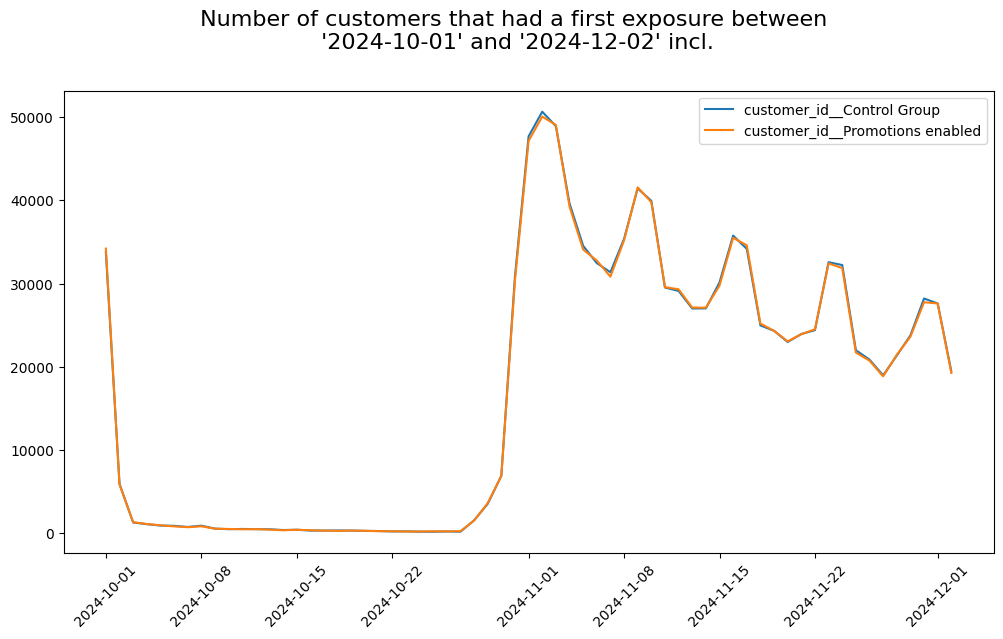

In [15]:
tmp = df.copy()

tmp['first_exposure_at'] = pd.to_datetime(tmp['first_exposure_at'])
grouped = tmp.groupby(['first_exposure_at','variant'])['customer_id'].nunique().reset_index()
grouped.sort_values(by=['first_exposure_at','variant'],ascending=[True,True], inplace=True)
pivot = grouped.pivot(index = 'first_exposure_at', columns='variant', values=['customer_id'])
pivot.columns = [f'{col[0]}__{col[1]}' for col in pivot.columns]
pivot = pivot.reset_index()
pivot = pivot.fillna(0)

v = dataframe_visualizer.DataFrameVisualizer(pivot)

plot_params = [
    {
        'plot_type': 'lineplot', 
        'x_column': 'first_exposure_at', 
        'y_columns': ['customer_id__Control Group', 'customer_id__Promotions enabled'],
        'colors': ['blue', 'orange'],
        'legend': True
    }
]

figure_params = {
    'n_plots': 1,
    'fig_length': 12,
    'fig_height': 6, 
    'x_rotation': 45,
    'x_limits': None, 
    'y_limits': None, 
    'title': f' Number of customers that had a first exposure between \n {START_DATE} and {END_DATE} incl.'
}

v.plot(figure_params=figure_params, plot_params=plot_params)


# Q3: Metrics

In [2]:
from glovo_experimentation_analytics.analytics.experiment import Experiment

ModuleNotFoundError: No module named 'glovo_experimentation_analytics'